#### Project: Beans dataset

#### Programmer: Ricardo A. Leal

#### Date: 10/12/2020


##### Note:
Some of my features are processed in a similar way to what I have learn on different machine learning courses, books and websites. This is a basic project to get familiar with machine learning techniques.

In [1]:
#Libraries
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.image import resize
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

#Set seed to reproduce results
np.random.seed(42)
tf.random.set_seed(99)

### Get data

In [2]:
#Load data
dataset, info = tfds.load(name = 'beans', as_supervised = True, with_info = True)

In [3]:
#Check info about the dataset
print(info)

tfds.core.DatasetInfo(
    name='beans',
    version=0.1.0,
    description='Beans is a dataset of images of beans taken in the field using smartphone
cameras. It consists of 3 classes: 2 disease classes and the healthy class.
Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated
by experts from the National Crops Resources Research Institute (NaCRRI) in
Uganda and collected by the Makerere AI research lab.
',
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=1295,
    splits={
        'test': 128,
        'train': 1034,
        'validation': 133,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {beansdata,
        author="Makerere AI Lab",
        title="Bean disease dataset",
        month="January",
        year="2020",
        url="https://gi

In [4]:
#Split data into sets
train, validation, test = dataset['train'], dataset['validation'], dataset['test']

### Preprocess data

In [5]:
#Transform data to tf.float32 and scale the images
def preprocess_data(image, label):
  image = tf.cast(image, tf.float32)
  image = image/255.0
  return image, label

In [6]:
#Apply transformation to the sets
train_set = train.map(preprocess_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
validation_set = validation.map(preprocess_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_set = test.map(preprocess_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)

In [7]:
#Cache the elements in the datasets, shuffle them and prefetch them
train_set = train_set.cache().shuffle(info.splits['train'].num_examples).prefetch(tf.data.experimental.AUTOTUNE)

validation_set = validation_set.cache().shuffle(info.splits['train'].num_examples).prefetch(tf.data.experimental.AUTOTUNE)

test_set = test_set.cache().shuffle(info.splits['train'].num_examples).prefetch(tf.data.experimental.AUTOTUNE)

In [8]:
def resize_images_and_get_labels(dataset):
  #Lists to hold the data
  images = []
  labels = []

  for image, label in dataset.take(-1):
    images.append(image)
    labels.append(label.numpy())

  #Resize images
  resized_dataset = resize(images, [200,200], preserve_aspect_ratio = True, method = 'mitchellcubic')
  del images

  return np.array(resized_dataset), np.array(labels)


In [9]:
#Resize images and get data into numpy arrays
X_train, y_train = resize_images_and_get_labels(train_set)
X_val, y_val = resize_images_and_get_labels(validation_set)
X_test, y_test = resize_images_and_get_labels(test_set)

### Check balance of the classes

Counter({1: 348, 0: 345, 2: 341})


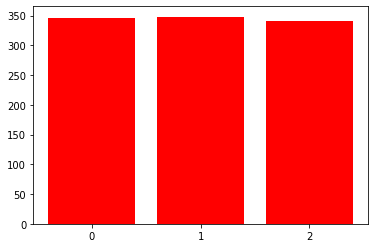

In [10]:
#Show balance of the classes in the validation set
dictionary_train_set = Counter(y_train)

#Print dictionary
print(dictionary_train_set)

#Plot values
plt.bar(x = range(len(dictionary_train_set)), height = list(dictionary_train_set.values()), color = 'r')
plt.xticks(ticks = range(len(dictionary_train_set)), labels = list(dictionary_train_set.keys()))
plt.show()

Counter({1: 45, 0: 44, 2: 44})


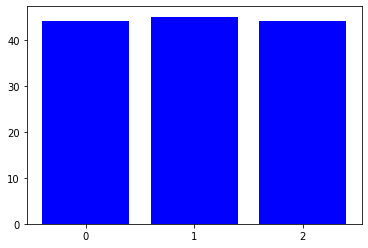

In [11]:
#Show balance of the classes in the validation set
dictionary_validation_set = Counter(y_val)

#Print dictionary
print(dictionary_validation_set)

#Plot values
plt.bar(x = range(len(dictionary_validation_set)), height = list(dictionary_validation_set.values()), color = 'b')
plt.xticks(ticks = range(len(dictionary_validation_set)), labels = list(dictionary_validation_set.keys()))
plt.show()

Counter({1: 43, 0: 43, 2: 42})


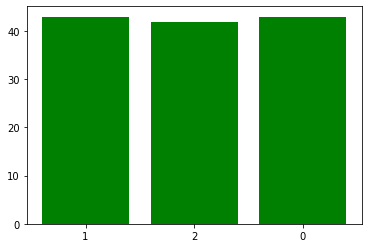

In [12]:
#Show balance of the classes in the test set
dictionary_test_set = Counter(y_test)

#Print dictionary
print(dictionary_test_set)

#Plot values
plt.bar(x = range(len(dictionary_test_set)), height = list(dictionary_test_set.values()), color = 'g')
plt.xticks(ticks = range(len(dictionary_test_set)), labels = list(dictionary_test_set.keys()))
plt.show()

### See some images

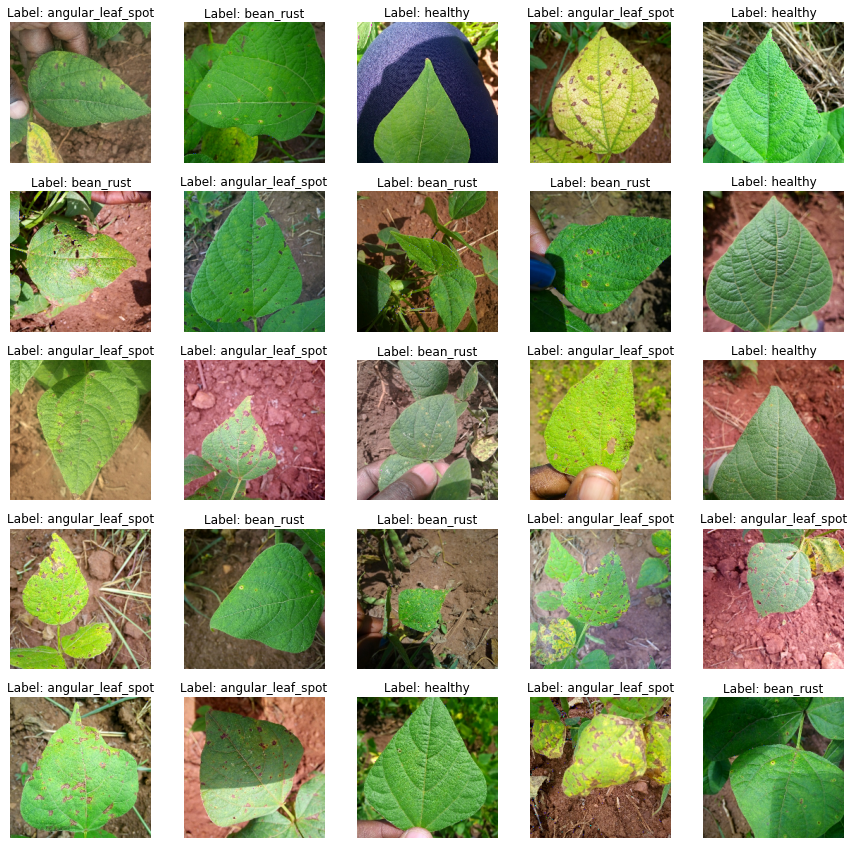

In [13]:
#Show some images of the train set

#Plot some images and show their label
rows, columns = 5, 5  
fig, axes = plt.subplots(rows, columns, figsize=(15,15))
axes = axes.ravel()
for i in range(0, rows*columns):
  axes[i].axis('off')
  axes[i].imshow((X_train[i] * 255).astype(np.uint8))
  axes[i].set_title("Label: {}".format(info.features['label'].names[y_train[i]]))


### Create model

In [14]:
#Variables for the model
num_classes = info.features['label'].num_classes
input_shape = X_train.shape[1:]
kernel_size = (3,3)
strides = (2,2)
padding = 'same'
activation = 'relu'
optimizer = Adam(learning_rate = 0.0001)

In [15]:
#Create model

inputs = Input(shape = input_shape)

#Convolution 1
x = Conv2D(filters = 32, kernel_size = kernel_size, padding = padding, strides = strides, activation = activation)(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (2,2))(x)

#Convolution 2
x = Conv2D(filters = 64, kernel_size = kernel_size, padding = padding, strides = strides, activation = activation)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (2,2))(x)

#Convolution 3
x = Conv2D(filters = 128, kernel_size = kernel_size, padding = padding, strides = strides, activation = activation)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (2,2))(x)

#Dense
x = Flatten()(x)
x = Dropout(rate = 0.2)(x)
outputs = Dense(num_classes, activation = 'softmax')(x)

#Model
model = Model(inputs, outputs)

In [16]:
#Summary
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)       

In [17]:
#Compile model
model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

### Train model

In [18]:
#Variables for training
epochs = 20
batch_size = 32

In [19]:
#Train model
history = model.fit(X_train, y_train, epochs = epochs,  batch_size = batch_size, validation_data = (X_val, y_val))

Epoch 1/20
33/33 [==============================] - 1s 25ms/step - loss: 1.7185 - accuracy: 0.4236 - val_loss: 1.0895 - val_accuracy: 0.3534
Epoch 2/20
33/33 [==============================] - 1s 18ms/step - loss: 0.9429 - accuracy: 0.6306 - val_loss: 1.0955 - val_accuracy: 0.4586
Epoch 3/20
33/33 [==============================] - 1s 18ms/step - loss: 0.7378 - accuracy: 0.7195 - val_loss: 1.1290 - val_accuracy: 0.3684
Epoch 4/20
33/33 [==============================] - 1s 18ms/step - loss: 0.6424 - accuracy: 0.7340 - val_loss: 1.1603 - val_accuracy: 0.3383
Epoch 5/20
33/33 [==============================] - 1s 18ms/step - loss: 0.5606 - accuracy: 0.7911 - val_loss: 1.2316 - val_accuracy: 0.3308
Epoch 6/20
33/33 [==============================] - 1s 18ms/step - loss: 0.4607 - accuracy: 0.8124 - val_loss: 1.2467 - val_accuracy: 0.3383
Epoch 7/20
33/33 [==============================] - 1s 18ms/step - loss: 0.4150 - accuracy: 0.8337 - val_loss: 1.2665 - val_accuracy: 0.3383
Epoch 8/20
33

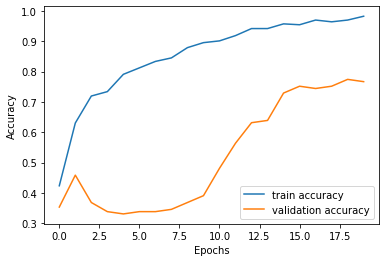

In [20]:
#Plot accuracy
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(loc = 'lower right')

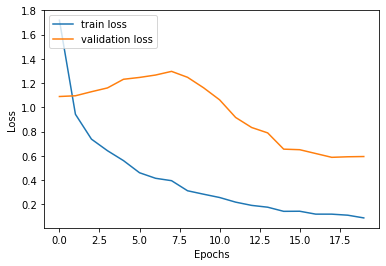

In [21]:
#Plot loss
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc = 'upper left')

## Data augmentation

In [22]:
#Data augmentation
data_gen = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1,  horizontal_flip= True)
generator = data_gen.flow(X_train, y_train, batch_size = batch_size, shuffle = True)

#Train model
history = model.fit(generator, epochs = epochs,  batch_size = batch_size, validation_data = (X_val, y_val))

Epoch 1/20
33/33 [==============================] - 8s 230ms/step - loss: 0.7954 - accuracy: 0.7041 - val_loss: 0.5476 - val_accuracy: 0.7895
Epoch 2/20
33/33 [==============================] - 8s 234ms/step - loss: 0.7366 - accuracy: 0.7302 - val_loss: 0.6589 - val_accuracy: 0.7444
Epoch 3/20
33/33 [==============================] - 8s 235ms/step - loss: 0.7410 - accuracy: 0.7282 - val_loss: 0.5452 - val_accuracy: 0.7895
Epoch 4/20
33/33 [==============================] - 8s 228ms/step - loss: 0.6938 - accuracy: 0.7263 - val_loss: 0.6872 - val_accuracy: 0.7519
Epoch 5/20
33/33 [==============================] - 8s 229ms/step - loss: 0.7617 - accuracy: 0.7273 - val_loss: 0.6963 - val_accuracy: 0.7368
Epoch 6/20
33/33 [==============================] - 8s 229ms/step - loss: 0.7246 - accuracy: 0.7398 - val_loss: 0.6040 - val_accuracy: 0.7519
Epoch 7/20
33/33 [==============================] - 8s 228ms/step - loss: 0.6799 - accuracy: 0.7456 - val_loss: 0.6848 - val_accuracy: 0.7368
Epoch 

In [23]:
#Data augmentation
data_gen = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1,  vertical_flip= True)
generator = data_gen.flow(X_train, y_train, batch_size = batch_size, shuffle = True)

#Train model
history = model.fit(generator, epochs = epochs,  batch_size = batch_size, validation_data = (X_val, y_val))

Epoch 1/20
33/33 [==============================] - 8s 231ms/step - loss: 0.7201 - accuracy: 0.7321 - val_loss: 0.6183 - val_accuracy: 0.7444
Epoch 2/20
33/33 [==============================] - 8s 234ms/step - loss: 0.6881 - accuracy: 0.7418 - val_loss: 0.7131 - val_accuracy: 0.7444
Epoch 3/20
33/33 [==============================] - 8s 234ms/step - loss: 0.6176 - accuracy: 0.7602 - val_loss: 0.6458 - val_accuracy: 0.7895
Epoch 4/20
33/33 [==============================] - 7s 227ms/step - loss: 0.6118 - accuracy: 0.7602 - val_loss: 0.5286 - val_accuracy: 0.7820
Epoch 5/20
33/33 [==============================] - 8s 228ms/step - loss: 0.6451 - accuracy: 0.7331 - val_loss: 0.5163 - val_accuracy: 0.8045
Epoch 6/20
33/33 [==============================] - 8s 229ms/step - loss: 0.6032 - accuracy: 0.7708 - val_loss: 0.3987 - val_accuracy: 0.7970
Epoch 7/20
33/33 [==============================] - 8s 228ms/step - loss: 0.5694 - accuracy: 0.7795 - val_loss: 0.5181 - val_accuracy: 0.7820
Epoch 

In [24]:
#Data augmentation
data_gen = ImageDataGenerator(zoom_range = 0.2)
generator = data_gen.flow(X_train, y_train, batch_size = batch_size, shuffle = True)

#Train model
history = model.fit(generator, epochs = epochs,  batch_size = batch_size, validation_data = (X_val, y_val))

Epoch 1/20
33/33 [==============================] - 7s 224ms/step - loss: 0.3637 - accuracy: 0.8607 - val_loss: 0.4371 - val_accuracy: 0.8120
Epoch 2/20
33/33 [==============================] - 7s 227ms/step - loss: 0.3512 - accuracy: 0.8685 - val_loss: 0.3782 - val_accuracy: 0.8271
Epoch 3/20
33/33 [==============================] - 8s 229ms/step - loss: 0.3219 - accuracy: 0.8704 - val_loss: 0.4013 - val_accuracy: 0.8271
Epoch 4/20
33/33 [==============================] - 7s 225ms/step - loss: 0.3140 - accuracy: 0.8704 - val_loss: 0.4480 - val_accuracy: 0.8120
Epoch 5/20
33/33 [==============================] - 7s 225ms/step - loss: 0.3064 - accuracy: 0.8772 - val_loss: 0.7005 - val_accuracy: 0.7444
Epoch 6/20
33/33 [==============================] - 7s 226ms/step - loss: 0.3069 - accuracy: 0.8743 - val_loss: 0.5574 - val_accuracy: 0.7744
Epoch 7/20
33/33 [==============================] - 7s 225ms/step - loss: 0.2735 - accuracy: 0.8936 - val_loss: 0.4985 - val_accuracy: 0.7895
Epoch 

In [25]:
#Data augmentation
data_gen = ImageDataGenerator(zca_whitening = True)
generator = data_gen.flow(X_train, y_train, batch_size = batch_size, shuffle = True)

#Train model
history = model.fit(generator, epochs = epochs,  batch_size = batch_size, validation_data = (X_val, y_val))

Epoch 1/20
 4/33 [==>...........................] - ETA: 0s - loss: 0.1108 - accuracy: 0.9531

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


33/33 [==============================] - 1s 24ms/step - loss: 0.1305 - accuracy: 0.9545 - val_loss: 0.3729 - val_accuracy: 0.8722
Epoch 2/20
33/33 [==============================] - 1s 23ms/step - loss: 0.1189 - accuracy: 0.9632 - val_loss: 0.5981 - val_accuracy: 0.7970
Epoch 3/20
33/33 [==============================] - 1s 23ms/step - loss: 0.0956 - accuracy: 0.9700 - val_loss: 0.3448 - val_accuracy: 0.8421
Epoch 4/20
33/33 [==============================] - 1s 23ms/step - loss: 0.0838 - accuracy: 0.9758 - val_loss: 0.3327 - val_accuracy: 0.8797
Epoch 5/20
33/33 [==============================] - 1s 23ms/step - loss: 0.0683 - accuracy: 0.9855 - val_loss: 0.3561 - val_accuracy: 0.8647
Epoch 6/20
33/33 [==============================] - 1s 23ms/step - loss: 0.0722 - accuracy: 0.9836 - val_loss: 0.3346 - val_accuracy: 0.8722
Epoch 7/20
33/33 [==============================] - 1s 23ms/step - loss: 0.0766 - accuracy: 0.9778 - val_loss: 0.3947 - val_accuracy: 0.8346
Epoch 8/20
33/33 [======

### Predictions

In [26]:
#Make predictions
predictions = model.predict(X_test).argmax(axis = 1)

### Evaluate

In [27]:
#valuate model
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 9ms/step - loss: 0.3207 - accuracy: 0.8906


[0.32066768407821655, 0.890625]

### Check results

In [28]:
#Classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89        43
           1       0.87      0.79      0.83        43
           2       0.95      0.95      0.95        42

    accuracy                           0.89       128
   macro avg       0.89      0.89      0.89       128
weighted avg       0.89      0.89      0.89       128




Confusion matrix



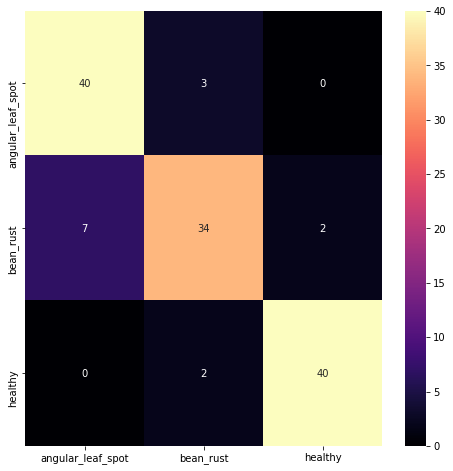

In [29]:
#Create a confusion matrix with the results from the predictions
print("\nConfusion matrix\n")
plt.figure(figsize = (8,8))
sns.heatmap(confusion_matrix(y_test, predictions), annot = True, fmt='d', cmap = 'magma',
            xticklabels = info.features['label'].names, yticklabels = info.features['label'].names)

The model performs well even though the dataset is very small. It mostly misclassifies angular_leaf_spot with bean_rust, which is understandable as they look similar in some cases due to the spots on the leaves. I am satisfied that it performs well with the healthy class